# `XMHW` Scaling Tests
The following will investigate the capability of `xmhw` to parallelise the MHW analysis on a subset of temperature data from the EAC-003 - 30th degree resolution, MOM6 simulation of the East Australian Current region. 

The first section just makes some plots of the region so feel free to skip that if need be. 
## Contents:

1. Load in Temperature Data and plot raw Temps

   - Here, we are using the 3D temperatures over a region off the east Australian coast spanning latitudes just north of Brisbane, to just south of Sydney. The data is from the 30th degree regional MOM6 model we call `eac-003`.
   - Due to the time-dependent, space-independent manner of a marine heatwave analysis, I have followed Thomas Moore's approach and saved the temperature data as a zarr file with single time-chunks, and spatial chunks equating to total chunk sizes of ~100 MB. I'm hoping that this should lead to an approach that only loads in data that is used immediately, rather than loading in large spatial chunks, only to use a small area for the computation.
     
2. Test `xmhw` on 1D data array

   - Here I'll test the code on a single 1D time-series to iron out any bugs within the main codebase of `xmhw`.
     
3. Scaling Tests for `xmhw`

- Given the memory of the current job, I'll explore how well the code can parallelise the tasks such that we can extraplolate to the entire domain. 
  


Using **conda env:analysis3**

In [10]:
# standard libraries
import numpy as np
import xarray as xr
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib import patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.lines as mlines
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from mpl_toolkits.mplot3d import Axes3D

# Optional modules
import cmocean as cmo
from datetime import date
import scipy as sci
from datetime import datetime as ddt

# Dask libraries
from dask.distributed import Client
# import dask

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
from xmhw.xmhw import threshold, detect

In [3]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35135/status,
Dashboard: /proxy/35135/status,Workers: 16
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42689,Workers: 16
Dashboard: /proxy/35135/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:42197,Total threads: 1
Dashboard: /proxy/33337/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:39605,


## 1. Import Temperature Data and plot

In [18]:
# temp_path = '/scratch/v45/jr5971/mom6-setonix/subsetted_data/zarr-files/'
# workdir = '/scratch/v45/jr5971/xmhw-question/'

# temp_name = 'eac-temp-time-jet_new2_rc.zarr' 
# temp_da = xr.open_zarr(temp_path + temp_name, consolidated=True)['thetao']
# eac_surface = temp_da.isel(z_l=0).drop_vars('z_l').chunk({'time':-1, 'xh':'auto', 'yh':'auto'})
# eac_surface.to_zarr(workdir + 'eac_surface.zarr')

In [19]:
%%time
workdir = '/scratch/v45/jr5971/xmhw-question/'
# sst_name = 'eac_surface.nc'
sst_name = 'eac_surface.zarr'
temp_da = xr.open_dataarray(workdir + sst_name)
temp_da

CPU times: user 63.2 ms, sys: 24.3 ms, total: 87.5 ms
Wall time: 82.2 ms


<xarray.DataArray 'thetao' (time: 9982, yh: 380, xh: 240)>
[910358400 values with dtype=float32]
Coordinates:
  * time     (time) object 1990-02-02 12:00:00 ... 2017-12-31 12:00:00
  * xh       (xh) float64 -210.0 -209.9 -209.9 -209.9 ... -202.1 -202.0 -202.0
  * yh       (yh) float64 -34.98 -34.96 -34.93 -34.9 ... -24.08 -24.04 -24.01
Attributes:
    cell_measures:  volume: volcello area: areacello
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degC

In [20]:
temp_da.encoding

{'chunks': (9982, 72, 45),
 'preferred_chunks': {'time': 9982, 'yh': 72, 'xh': 45},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'missing_value': 1.0000000200408773e+20,
 '_FillValue': 1e+20,
 'dtype': dtype('float32')}

Note the data is chunked in space, with single time chunks suitable for time-oriented analyses. 

### 1.1 Plotting (can be skipped)

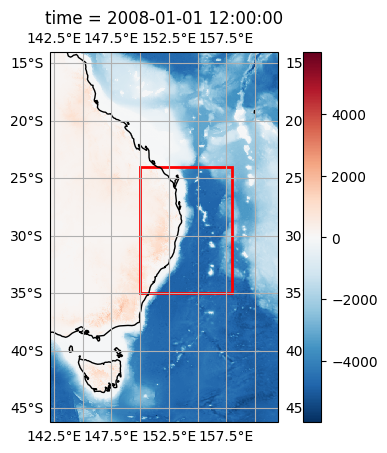

In [5]:
# get spatial limits;
bounds = {'W':temp_da.xh.min().values, 'E':temp_da.xh.max().values,
          'S':temp_da.yh.min().values, 'N':temp_da.yh.max().values}
# load topography for overview plot
eac_bath = xr.open_dataarray('/scratch/v45/jr5971/xmhw-question/gebco-rg-eac.nc')
eac_bath_sub = eac_bath.sel(lon=slice(bounds['W']+360, bounds['E']+360), 
                        lat=slice(bounds['S'], bounds['N']))
ax = plt.figure().add_subplot(projection=ccrs.PlateCarree())
eac_bath.plot(ax=ax, transform=ccrs.PlateCarree())
box = patches.Rectangle((bounds['W']+360, bounds['S']), (bounds['E']-bounds['W']), 
                        (bounds['N']-bounds['S']), fill=None, edgecolor='r',linewidth=2)
ax.add_patch(box)
ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree())
ax.coastlines()

Make a nice 3D plot;

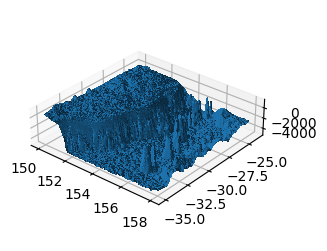

In [8]:
X_geb, Y_geb = np.meshgrid(eac_bath_sub['lon'], eac_bath_sub['lat'])
Z = eac_bath_sub.values 
Z_nonans = np.nan_to_num(Z, nan=0)
ax = plt.figure(figsize=(6,3)).add_subplot(projection='3d')
surf = ax.plot_surface(X_geb, Y_geb, Z, rstride=1, cstride=1, antialiased=False)
ax.view_init(elev=30, azim=-50)
ax.set_box_aspect((4,4,1))

In [8]:
%%time
# select time slice and make 3D plot
da_3d = temp_da.isel(time=10).compute()
da_3d = da_3d.rename({'yh':'lat', 'xh':'lon'})
da_3d['lon'] = da_3d['lon'] + 360

CPU times: user 26.7 s, sys: 3.09 s, total: 29.8 s
Wall time: 2min 38s


(240, 380, 100) (240, 380, 100)
(380, 240) (240,)


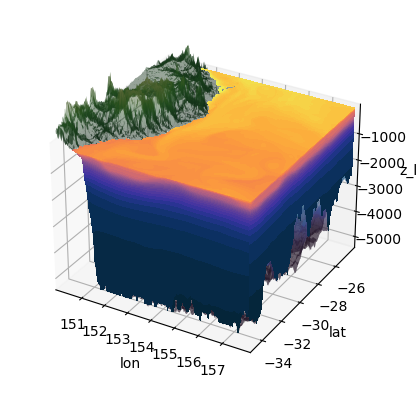

In [9]:
kw = {'cmap':cmo.cm.thermal, 'vmin':0, 'vmax':32,
      'levels':30, 'zorder':1}

x, y, z = da_3d['lon'], da_3d['lat'], da_3d['z_l']
X, Y, Z = np.meshgrid(x, y, -z)
X = X.transpose((1,0,2))
Y = Y.transpose((1,0,2))
Z = Z.transpose((1,0,2))
data = da_3d.data.T
print(X.shape, data.shape)

# get 2d coast arrays
X_geb, Y_geb = np.meshgrid(eac_bath_sub['lon'], eac_bath_sub['lat'])
print(X_geb.shape, eac_bath_sub['lon'].shape)
geb_nowater = eac_bath_sub.where(eac_bath_sub >=0, np.nan)


ax = plt.figure(figsize=(5,5)).add_subplot(projection='3d', computed_zorder=False)

bath = ax.plot_surface(X_geb, Y_geb, eac_bath_sub.values, rstride=1, cstride=1,
                       cmap=cmo.cm.topo, vmin=-4000, vmax=4000, alpha=0.5, zorder=0)

# lat_idx = len(y)//2
# lat = y[lat_idx].values

Cy = ax.contourf(X[:, 0, :], data[:, 0, :], Z[:,0,:], 
                 zdir='y', offset=Y.min(), **kw)
Cx = ax.contourf(data[-1,:,:], Y[-1,:,:], Z[-1,:,:], 
                 zdir='x', offset=X.max(), **kw)
Cz = ax.contourf(X[:,:,0],Y[:,:,0],data[:,:,0], 
                 zdir='z', offset=0, **kw)
# Set limits of plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])
# set labels
ax.set(
    xlabel='lon',
    ylabel='lat',
    zlabel='z_l',
    # zticks=[0,-150,-300,-450],
)
# ax.view_init(elev=20, azim=-70, roll=1)
ax.set_box_aspect(None, zoom=0.9)

## 2. Test `xmhw` on 1D time series (also can be skipped)

In [9]:
da1d = temp_da.isel(xh=200, yh=200, z_l=0).compute()
da1d

<xarray.DataArray 'thetao' (time: 9982)>
array([22.705942, 22.737684, 22.929747, ..., 26.106499, 25.689236,
       25.545448], dtype=float32)
Coordinates:
  * time     (time) object 1990-02-02 12:00:00 ... 2017-12-31 12:00:00
    xh       float64 -203.3
    yh       float64 -29.34
    z_l      float64 0.2928
Attributes:
    cell_measures:  volume: volcello area: areacello
    cell_methods:   area:mean z_l:mean yh:mean xh:mean time: mean
    long_name:      Sea Water Potential Temperature
    standard_name:  sea_water_potential_temperature
    time_avg_info:  average_T1,average_T2,average_DT
    units:          degC

For MOM6 Data, need to change cftime to datetime

In [10]:
da1d['time'] = da1d['time'].astype('datetime64[ns]')

Calculate climatology and 90th percentile threshold

In [12]:
%%time
clim = threshold(da1d)

calendar not in keys
CPU times: user 1.55 s, sys: 391 ms, total: 1.94 s
Wall time: 5.21 s


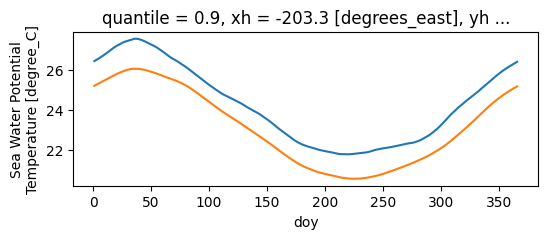

In [13]:
plt.figure(figsize=(6,2))
clim['thresh'].plot()
clim['seas'].plot()

### Detecting MHW events
Now that we have the climatologies we can run detect

In [14]:
# set path to save results if required
mhw_path = '/home/581/jr5971/jr5971/mhw-analysis/eac-jet-mhws/'

In [15]:
%%time
mhw, intermediate = detect(da1d, clim['thresh'], clim['seas'], intermediate=True)
# mhw.to_netcdf(mhw_path + 'mhw1d.nc')
# intermediate.to_netcdf(mhw_path + 'int1d.nc')

/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfout.loc[:,d] = val[0]
/g/data/v45/jr5971/new-pet-env.3.9.2/lib/python3.9/site-packages/xmhw/features.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

CPU times: user 786 ms, sys: 179 ms, total: 965 ms
Wall time: 2.22 s


Alright, so detecting events is much quicker than calculating the climatologies/90th percentiles. So we've detected 48 MHW events within this single grid cell.

### Block average
The blockAverage function calculates statistics along a block of time. Most of the statistics calculated on the block are simple statistics. Given that the mhw properties are saved now as an array it is simple to calculate them after grouping by year or 'bins' of years on the entire dataset. 

**Note**: Currently the `block_average` function only works with conda environment `Analysis3.22.04`. I haven't looked any further into the specific issue with later environments. 

In [13]:
from xmhw.stats import block_average

In [23]:
temp_da.time

<xarray.DataArray 'time' (time: 9982)>
array([cftime.DatetimeJulian(1990, 2, 2, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1990, 2, 3, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1990, 2, 4, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeJulian(2017, 12, 29, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2017, 12, 30, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2017, 12, 31, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 1990-02-02 12:00:00 ... 2017-12-31 12:00:00
Attributes:
    axis:           T
    bounds:         time_bnds
    calendar_type:  JULIAN
    long_name:      time

**Things to Note**:
- Block average requires `dstime` argument to be a **non-cftime** time array. 

In [14]:
%%time
blockav = block_average(mhw, dstime=da1d)

Assuming time is time dimension


2024-04-15 12:45:24,501 - distributed.worker - WARNING - Compute Failed
Key:       call_groupby-2bc0ab2a-6feb-4399-9459-11993bf0bc95
Function:  call_groupby
args:      (<xarray.Dataset>
Dimensions:                         (events: 48)
Coordinates:
  * events                          (events) float64 316.0 642.0 ... 9.972e+03
Data variables: (12/34)
    event                           (events) float64 316.0 642.0 ... 9.972e+03
    index_start                     (events) float64 316.0 642.0 ... 9.972e+03
    index_end                       (events) float64 320.0 649.0 ... 9.977e+03
    time_start                      (events) datetime64[ns] 1990-12-15T12:00:...
    time_end                        (events) datetime64[ns] 1990-12-19T12:00:...
    time_peak                       (events) datetime64[ns] 1990-12-15T12:00:...
    ...                              ...
    intensity_var_relThresh         (events) float64 0.3534 0.4788 ... 0.43
    intensity_var_abs               (events) float32

KeyError: 'agg_mhw'

Alrighty, well that's it for a single 1d time-series. The main thing to note is that we have to switch back to an old conda environment if wanting to use the block average functions. 

Now let's figure out how many we can do at once such that the speed of the computation remains much the same. 

## 3. Scaling tests for `xmhw`

Okay, so given the memory we have available, let's select a chunk of data to test the parallelisation of the code with. 

In [23]:
client.ncores

<bound method Client.nthreads of <Client: 'tcp://127.0.0.1:42689' processes=16 threads=16, memory=64.00 GiB>>

In [24]:
# Check available memory
import psutil
print(f'Available memory: {psutil.virtual_memory().available/1e9} GB')

Available memory: 75.00353536 GB


So, not sure why there's the mismatch between the "total memory" in the dask client, and the total memory given by the `psutil.virtual_memory().available` function. Is this something to do with `JOBFS`?

Now, before we get into the scaling, I'd like to demonstrate the issue that happens when we try the `threshold` function on a array with size greater than say 50 MB. 

In [ ]:
start = ddt.now()
n_x = 40
n_y = 70
array_50mb = temp_da.isel(yh=slice(0, n_y), xh=slice(-n_x, None)).compute()
print(f'data size = {array_50mb.nbytes/1e6} MB')
load_time = (ddt.now() - start).total_seconds()
print(f'time to load: {load_time}')
# compute threshold
array_50mb['time'] = array_50mb['time'].astype('datetime64[ns]')
clim = threshold(array_50mb)
total_time = (ddt.now() - start).total_seconds()
print(f'total time to compute: {total_time}')

**Questions to do with dashboard:**
* When the Task Stream expands out from say 8 rows, to a large number of rows (> 50) what is actually happening? Is it that each worker is handling many small tasks in parallel?
* 

### Setup scaling function

In [14]:
def scale_time(array, n_y, n_x, compute=True):
    '''
    Function to test the scaling of `xmhw` given a 2D array
    '''
    # start timer
    start = ddt.now()
    # select number of lon/lat points starting from SE corner of domain
    array_sub = array.isel(yh=slice(0, n_y), xh=slice(-n_x,None)) #note requirement to drop z
    print(f'array size: {array_sub.nbytes/1e6} MB')
    try:
        array_sub['time'] = array_sub['time'].astype('datetime64[ns]')
    except:
        print('array already in datetime format')
    print(f'Array shape: {array_sub.shape}')
    if compute == True:
        array_sub = array_sub.compute()
        data_load = ddt.now()
    else:
        print('not computing array before threshold')
    # compute threshold
    clim = threshold(array_sub)
    end = ddt.now()
    print(f'Total Time: {end-start}')
    # get times
    load_time = (data_load - start).total_seconds()
    threshold_time = (end - data_load).total_seconds()
    total_time = (end-start).total_seconds()
    return array_sub.nbytes/1e6, load_time, threshold_time, total_time

Step through the 2D temperature array, doubling the size each time, and recording the time taken to process the result. 

In [15]:
%%capture
scaling_results = []
for i in range(10):
    # array size
    n_x = 5
    n_y = (i+1) * 10
    scaling_results.append(scale_time(temp_da, n_x, n_y, compute=True))
    
# convert to numpy array
results = np.array(scaling_results)

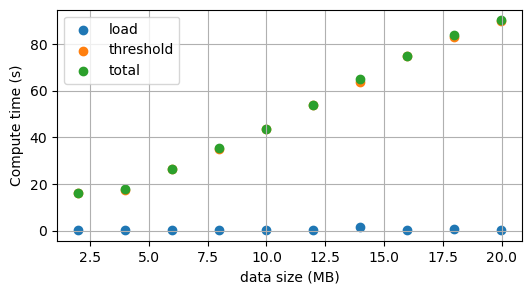

In [17]:
# plot
plt.figure(figsize=(6,3))
plt.scatter(results[:,0], results[:,1], label='load')
plt.scatter(results[:,0], results[:,2], label='threshold')
plt.scatter(results[:,0], results[:,3], label='total')
plt.xlabel('data size (MB)'); plt.ylabel('Compute time (s)')
plt.grid(); plt.legend()

**NOTE**: in the last scaling test above, the computation crashed on the 6th iteration; The data size was (lat:70 x lon:40) equating to **111MB**. The job info is as below: (16 processes). So the question is - why are the workers killed? This *unmanaged memory* seems to be the cause - can this be fixed? 

In [23]:
client.ncores

<bound method Client.nthreads of <Client: 'tcp://127.0.0.1:41845' processes=16 threads=16, memory=64.00 GiB>>


* CPU Considerations:
    - The number of tasks should scale linearly with the number of grid-cells (and hence the size of the input array)
 
* Memory Considerations: ...

Questions: 
* What limit is reached first? Too many tasks, or too much memory load - does this question even make sense?
* What does this warning message really mean?
  
    `distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.76 GiB -- Worker memory limit: 4.00 GiB`

  According to dask documentation: "*[dask] can overestimate — sometimes significantly — how much memory the process is using and think the worker is running out of memory when in fact it isn’t*"

